# Guided Project: Popular Data Science Questions
by Ilia Koloiarov

<br>
Toady we are playing in scenario, where our company creates content in the field of the Data Science (book, podcasts, literature, articles and so on). We were tasked to find out what the most popular topics in this field are. We choose [Stack Exchange](https://datascience.stackexchange.com) as data source for our analysis due to its popularity, multitude of fields and its reputation award system (which allows us to distinguish likely answered questions from ignored). But there are several questions before.
<br>
**What kind of questions are welcome on this site?**
From what I've looked through likely answered questions should be:
- focused 
- do not require subjective opinion
- was not asked before

**What, other than questions, does the site's home subdivide into?** Does any of them look useful towards our goal?
- tags (yes, we can categorize the topic with tags)
- users (yes, maybe, some of the quesitons are likely to answered due to site's audicity)
- unanswered (yes, there are all charecteristics of unanswered questions which we need to avoid)

**What information is available in each post?**
- body of the question
- its ranking (upvotes - downvotes)
- amount of replies
- bodies of replies
- its tags

Now comes the question of mining the data. One potentional solution would be to scrape. However, because I haven't still learn how to scrape appropriately, and because there is an easier alternative, we are doing with Stack Exchande public [data base](https://data.stackexchange.com/datascience/query/new). Which tables we are interested in ?
- Posts (especially, number of answers, score, number of views, etc.)
- Tags (provide us with overview of all topics)

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:
- Id: An identification number for the post.
- PostTypeId: An identification number for the type of post.
![Image](https://dq-content.s3.amazonaws.com/469/PostTypes.png)
- CreationDate: The date and time of creation of the post.
- Score: The post's score.
- ViewCount: How many times the post was viewed.
- Tags: What tags were used.
- AnswerCount: How many answers the question got (only applicable to question posts).
- FavoriteCount: How many times the question was favored (only applicable to question posts).


There are eight different types of post. Before we try to figure out which of them are relevant to us, let's check how many of them there are:

|PostTypeId|NrOfPosts|
|----------|---------|
|1|21446|
|2|	23673|
|4|	236|
|5|	236|
|6|	11|
|7|	1|
Due to their low volume, anything that isn't questions or answers is mostly inconsequential. We are exctracting data with following query:

`SELECT 
  Id, PostTypeId, CreationDate, Score,
  ViewCount, Tags, AnswerCount, FavoriteCount
FROM posts
WHERE PostTypeID IN (1,2)
AND YEAR(CreationDate) = 2019`

## Overview of data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('2019_questions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


In [2]:
df.describe()

,Id,Score,ViewCount,AnswerCount,FavoriteCount
count,8839.000000,8839.000000,8839.000000,8839.000000,1407.000000
mean,54724.172870,0.870687,171.548026,0.787985,1.184790
std,6507.618509,1.410255,772.813626,0.851146,0.982766
min,43363.000000,-2.000000,2.000000,0.000000,0.000000
25%,48917.500000,0.000000,22.000000,0.000000,1.000000
50%,54833.000000,1.000000,40.000000,1.000000,1.000000
75%,60674.500000,1.000000,98.000000,1.000000,1.000000
max,65675.000000,45.000000,33203.000000,9.000000,16.000000


In [3]:
df['Tags']

0                         <machine-learning><data-mining>
1       <machine-learning><regression><linear-regressi...
2            <python><time-series><forecast><forecasting>
3                   <machine-learning><scikit-learn><pca>
4                <dataset><bigdata><data><speech-to-text>
5                                           <fuzzy-logic>
6       <time-series><anomaly-detection><online-learning>
7                                  <matrix-factorisation>
8                   <correlation><naive-bayes-classifier>
9       <machine-learning><python><deep-learning><kera...
10                                     <machine-learning>
11                             <machine-learning><theory>
12                   <machine-learning><gradient-descent>
13      <nlp><clustering><feature-extraction><encoding...
14                  <python><scikit-learn><pandas><numpy>
15      <python><scikit-learn><decision-trees><accurac...
16                                       <python><pandas>
17            

What do we see ?
- there are 7432 null values in 'FavoriteCount' column ( we can fill it with 0)
- the columns 'CreationDate' and 'FavoriteCount' has unappropriate type of data (should be datetime and int64 respectively)
- the 'Tags' column constists of strings. Thus, should be replaced with a list of tags for each row.

In [4]:
# fill out missing values with 0 in the FavouriteCount column
df['FavoriteCount'].fillna(0, inplace = True)

In [5]:
# Setting adequate types of data
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

In [6]:
df['FavoriteCount'] = df['FavoriteCount'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


In [8]:
df['Tags'] = df['Tags'].str.replace('<', '')
df['Tags'] = df['Tags'].str.replace('>', ' ')

In [9]:
# Transform into lists of tags
df['Tags'] = df['Tags'].str.split()

In [10]:
# Making a frequency table of all tags
tags = {}
for i, r in df.iterrows():
    views = r['ViewCount']
    for t in r['Tags']:
        if t in tags:
            tags[t] = [tags[t][0] + 1, tags[t][1] + views]
        else:
            tags[t] = [1, views]

In [11]:
# Tried to add column names at first step lead to an error (as I got, it's due to the python version)
df_tags = pd.DataFrame.from_dict(tags, orient = 'index')
df_tags.columns = ['occurrences', 'views']

In [12]:
df_tags

,occurrences,views
corpus,1,23
auc,3,67
markov,4,183
groupby,2,57
kitti-dataset,1,7
text-filter,2,47
self-study,8,1162
counts,3,113
nl2sql,1,14
management,2,68


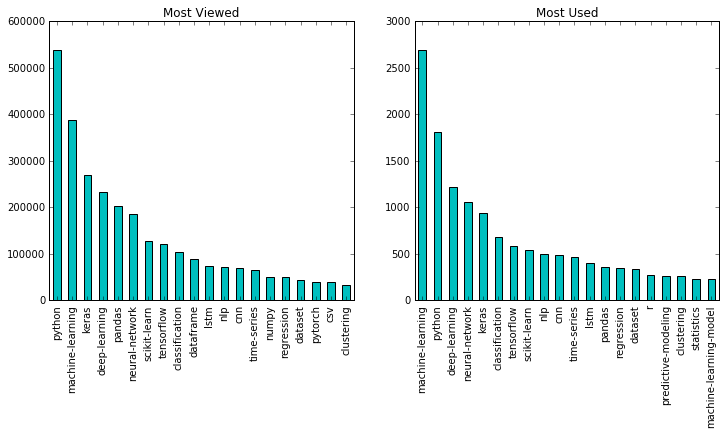

In [41]:
#find most viewed and occured tags
most_viewed = df_tags['views'].sort_values(ascending = False).head(20)
most_occurred = df_tags['occurrences'].sort_values(ascending = False).head(20)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (12, 5))
most_viewed.plot(kind = 'bar', ax = ax1, title = 'Most Viewed', color = 'c')
most_occurred.plot(kind = 'bar', ax = ax2, title = 'Most Used', color = 'c')

In [43]:
# lets union all tags and make weighted values (just for fun) for views and occurences to show popularity of tags explicitly
valuable_tags = most_viewed.index.union(most_occurred.index)
df_check = df_tags.copy()
df_check['w_occ'] = (df_check['occurrences'] - df_check['occurrences'].min())/ (df_check['occurrences'].max() - df_check['occurrences'].min())
df_check['w_views'] = (df_check['views'] - df_check['views'].min())/ (df_check['views'].max() - df_check['views'].min())
barh = df_check.loc[valuable_tags, ['w_occ', 'w_views']]
barh['score'] = barh['w_occ'] + barh['w_views']
barh = barh.sort_values('score', ascending = False)

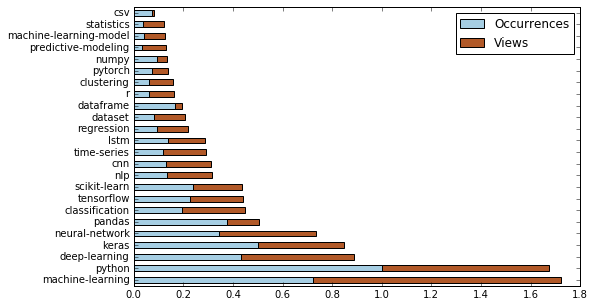

In [45]:
# Visualising
fig, ax = plt.subplots(figsize = (8, 5))
barh[['w_views', 'w_occ']].plot(kind = 'barh', ax = ax, stacked = True,  colormap = 'Paired')
ax.legend(['Occurrences', 'Views'])
plt.show()

Now we can explicitly observe the most popular tags based on their views and usage.